# preprocessing

In [81]:
!rm -rf TabularDS  # Remove the existing directory
!git clone https://github.com/ItamarBerger/TabularDS


Cloning into 'TabularDS'...
remote: Enumerating objects: 516, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 516 (delta 44), reused 32 (delta 11), pack-reused 387 (from 2)
Receiving objects: 100% (516/516), 39.08 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (216/216), done.
Updating files: 100% (19/19), done.


# 1. MovieLens 20M dataset

In [82]:
import pandas as pd
transactions = pd.read_csv('/content/TabularDS/final_project/data/movies_with_clusters.csv')
min_support = 0.25
# take a smaller sample of given dataset, reducing time & space complexity
transactions = transactions[0:20000]

## I. Applying Classic Apriori for rule associasion mining

In [83]:
# data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# data.dropna(subset=['InvoiceNo', 'Description'], inplace=True)

# transactions = data.groupby('CustomerID')['Description'].apply(list).tolist()
# print(f"number of transactions is: {len(transactions)}")

In [84]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules


frequent_itemsets = fpgrowth(transactions, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Baseline apriori results

In [85]:
if not rules.empty:
  print(f"number of rules is: {len(rules)}")
  print(rules[0:3])

number of rules is: 126
                                         antecedents  \
0                 (Silence of the Lambs, The (1991))   
1                              (Pulp Fiction (1994))   
2                              (Forrest Gump (1994))   
3                 (Silence of the Lambs, The (1991))   
4  (Forrest Gump (1994), Silence of the Lambs, Th...   
5         (Forrest Gump (1994), Pulp Fiction (1994))   
6  (Silence of the Lambs, The (1991), Pulp Fictio...   
7                              (Forrest Gump (1994))   
8                 (Silence of the Lambs, The (1991))   
9                              (Pulp Fiction (1994))   

                                         consequents  antecedent support  \
0                              (Pulp Fiction (1994))             0.46705   
1                 (Silence of the Lambs, The (1991))             0.50005   
2                 (Silence of the Lambs, The (1991))             0.49420   
3                              (Forrest Gump (1994))   

In [86]:
import numpy as np

def print_basic_metrics(rules):
  # Calculate the average support, confidence, and lift from the rules DataFrame
  avg_support = np.mean(rules['support'])
  avg_confidence = np.mean(rules['confidence'])
  avg_lift = np.mean(rules['lift'])

  # Print the metrics
  print(f"\nMetrics: Support average: {avg_support:.4f}, Confidence average: {avg_confidence:.4f}, Lift average: {avg_lift:.4f}")


print_basic_metrics(rules)
# Store the rules and itemsets for later use
original_rules = rules
original_itemsets = frequent_itemsets



Metrics: Support average: 0.2772, Confidence average: 0.6727, Lift average: 1.6101


## Visualize top rules
### (sorted by lift)

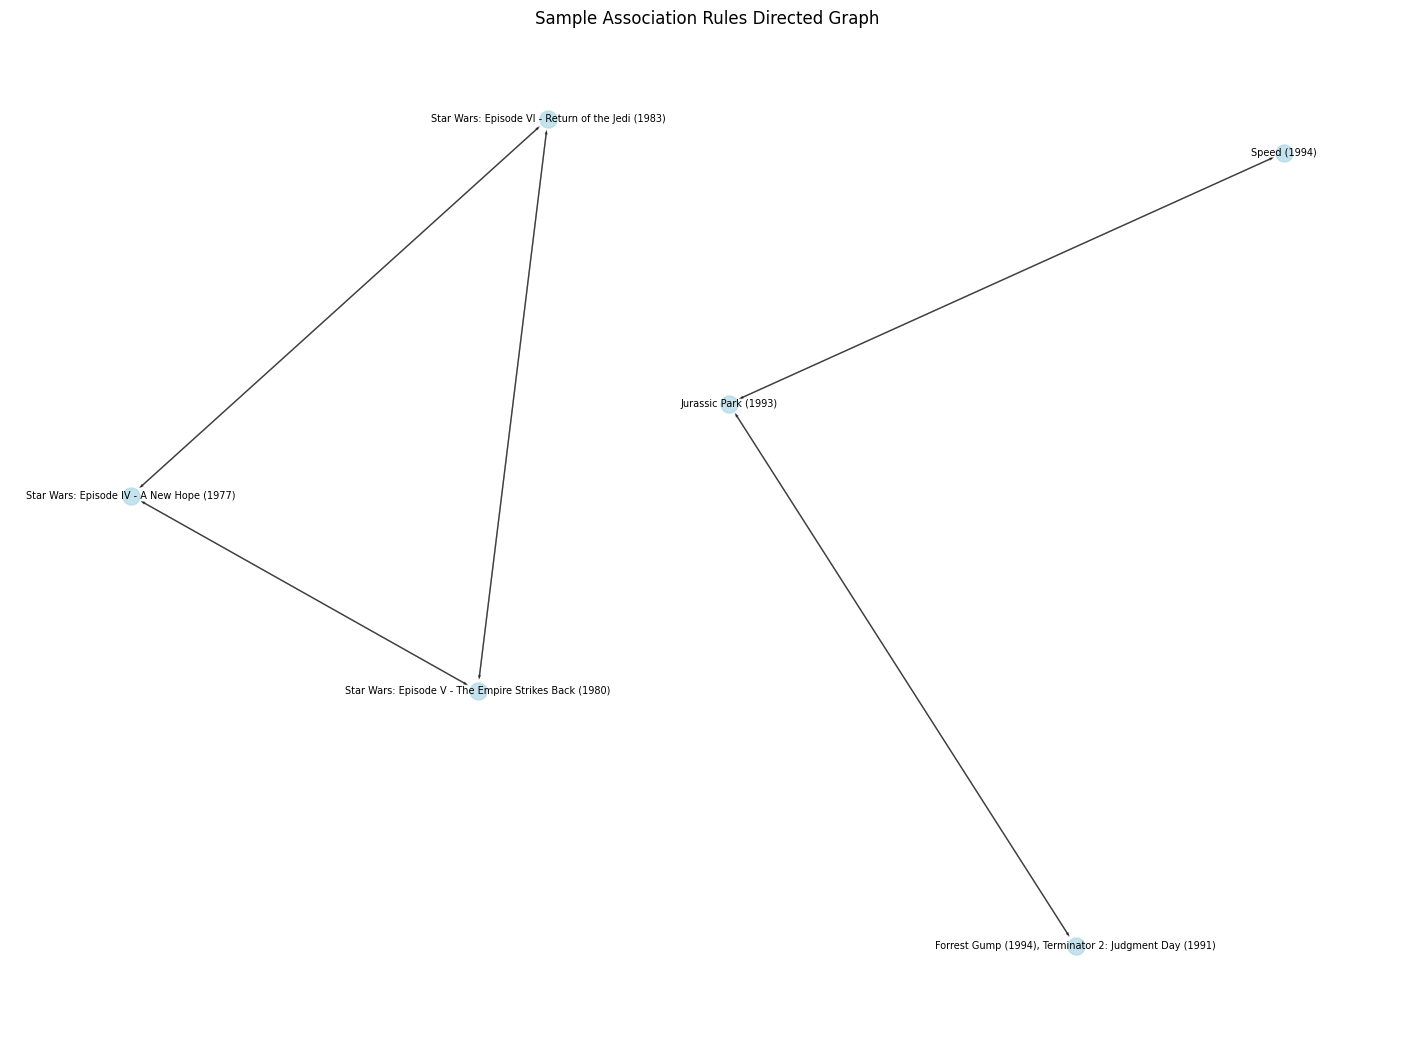

In [87]:
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules
def plot_topk_rules_in_graph(rules, frequent_itemsets, k=10):

    # Create a directed graph
    G = nx.DiGraph()
    narrow_rules = rules.sort_values(by='lift', ascending=False).head(k)
    # Add nodes and directed edges
    for _, rule in narrow_rules.iterrows():
        antecedent = ', '.join(list(rule['antecedents']))
        consequent = ', '.join(list(rule['consequents']))

        # Add a directed edge from antecedent to consequent
        G.add_edge(antecedent, consequent)

    # Draw the directed graph
    plt.figure(figsize=(18, 13))
    pos = nx.spring_layout(G, k=0.5, iterations=k)  # Layout for the graph

    # Draw the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=150, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, arrowstyle='->', arrowsize=3)
    nx.draw_networkx_labels(G, pos, font_size=7, font_color='black')

    # Add edge labels (optional, if you want to display lift, confidence, or support)
    # edge_labels = nx.get_edge_attributes(G, 'weight')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Sample Association Rules Directed Graph")
    plt.axis('off')
    plt.show()

plot_topk_rules_in_graph(rules, frequent_itemsets)

max lift value is 2.2712
max confidence value is 0.8676


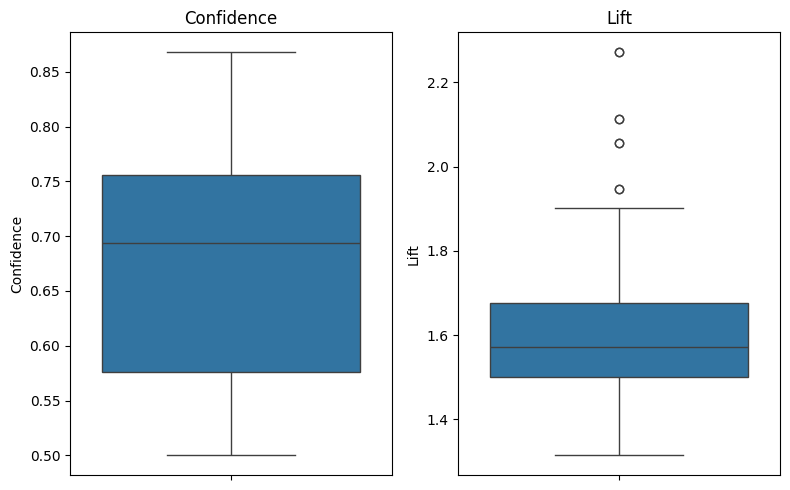

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics_boxplots(rules):
  if not rules.empty:


      print(f"max lift value is {rules['lift'].max():.4f}")
      print(f"max confidence value is {rules['confidence'].max():.4f}")

      fig, axes = plt.subplots(1, 2, figsize=(8, 5))

      # plot Confidence
      sns.boxplot(data=rules['confidence'], ax=axes[0])
      axes[0].set_title('Confidence')
      axes[0].set_ylabel('Confidence')

      # plot Lift
      sns.boxplot(data=rules['lift'], ax=axes[1])
      axes[1].set_title('Lift')
      axes[1].set_ylabel('Lift')

      # show plot
      plt.tight_layout()
      plt.show()
  else:
      print("No rules to plot.")



plot_metrics_boxplots(rules)


# Cluster items + Apriori


In [89]:
from sklearn.cluster import KMeans


def add_cluster_users_col(num_clusters, transactions_matrix):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    user_clusters = kmeans.fit_predict(transactions_matrix)
    transactions_matrix['Cluster'] = user_clusters


num_clusters = 50
add_cluster_users_col(num_clusters,transactions)
df = transactions

<ipython-input-90-97f26412de46>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')


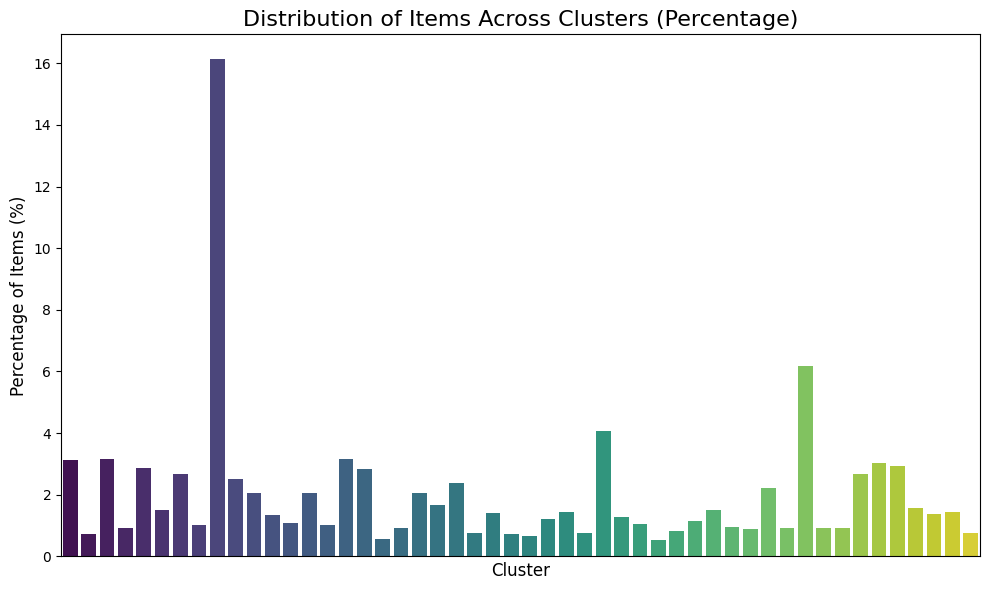

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the distribution of clusters (as percentages only)
cluster_percentages = (df['Cluster'].value_counts(normalize=True) * 100).sort_index()

# Plot the distribution using seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Items Across Clusters (Percentage)', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage of Items (%)', fontsize=12)

# Remove x-tick labels (to avoid showing the cluster index)
plt.xticks([])

# Show the plot
plt.tight_layout()
plt.show()



Processing Cluster 0...
Sparsity of Cluster 0: 0.8711, ize of Cluster is: 627


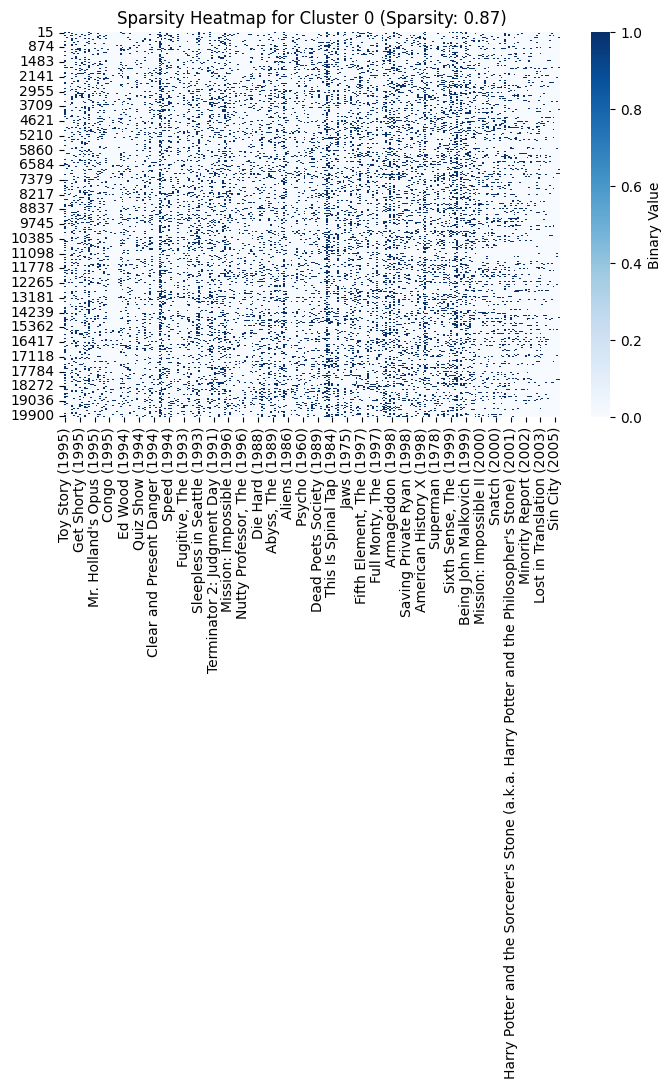

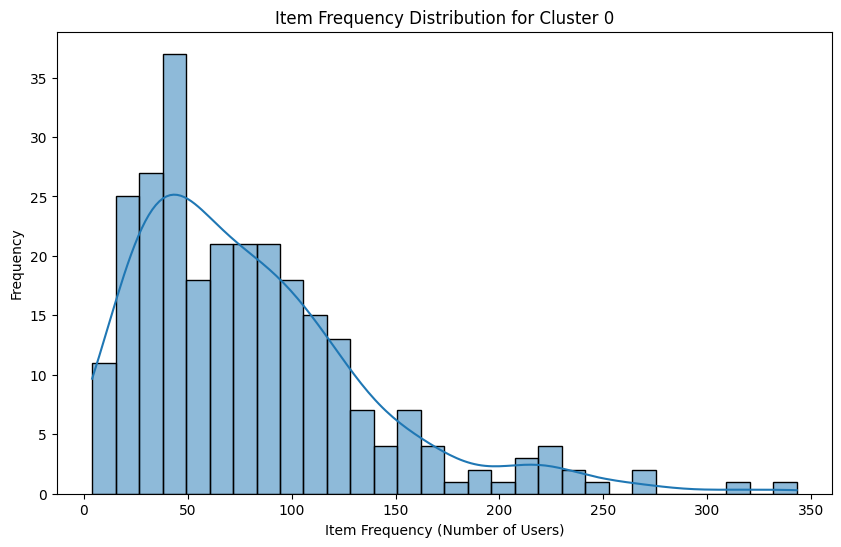

Cluster 0: 0 rules generated.

Processing Cluster 2...
Sparsity of Cluster 2: 0.8658, ize of Cluster is: 631


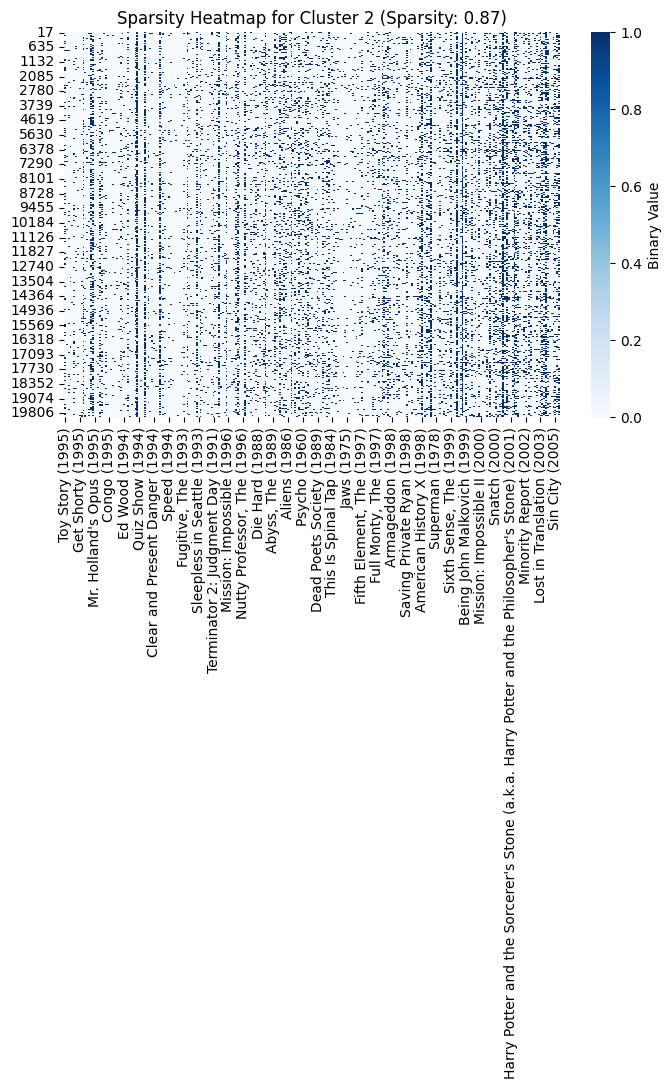

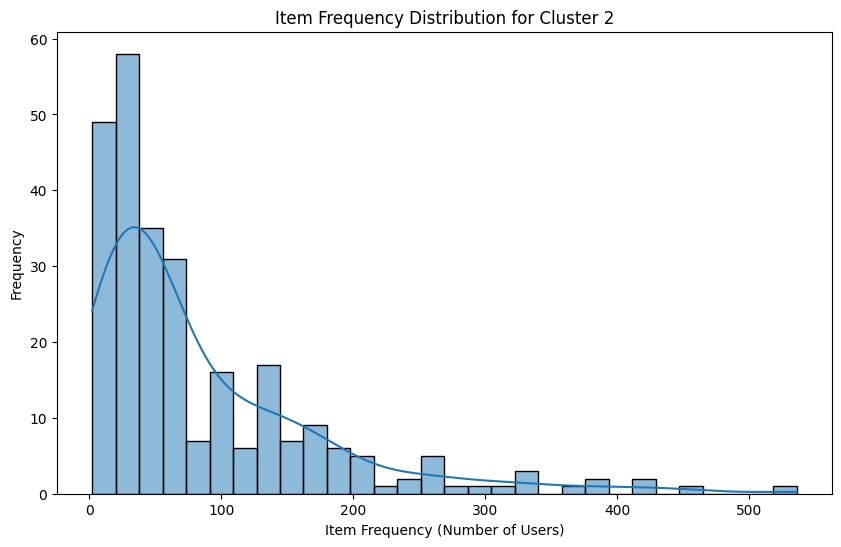

Cluster 2: 14 rules generated.

Processing Cluster 4...
Sparsity of Cluster 4: 0.8817, ize of Cluster is: 577


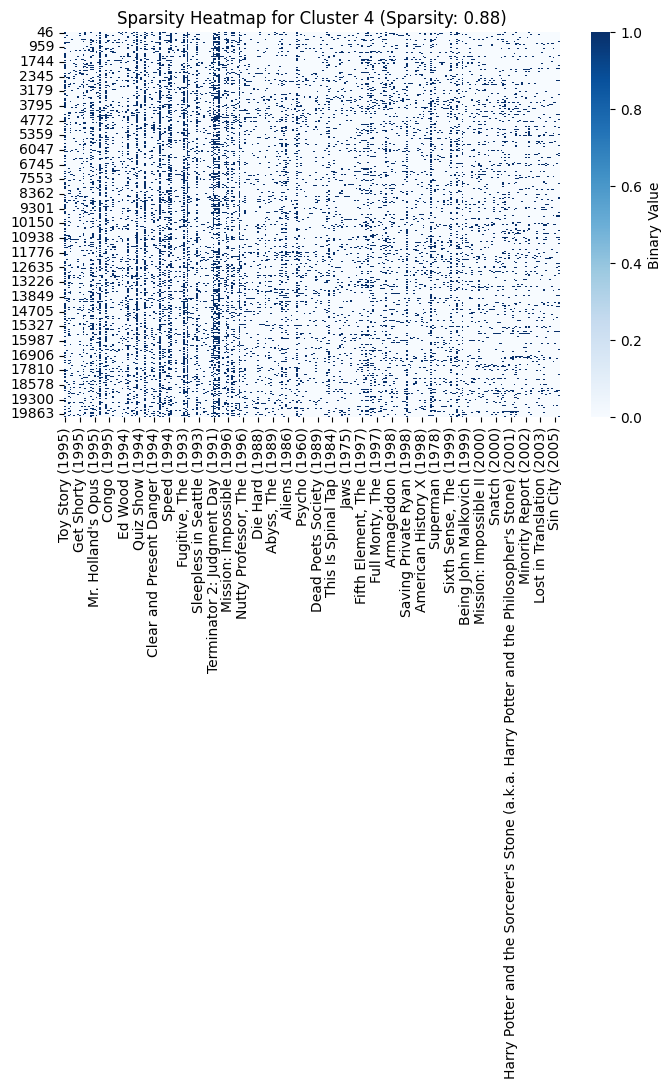

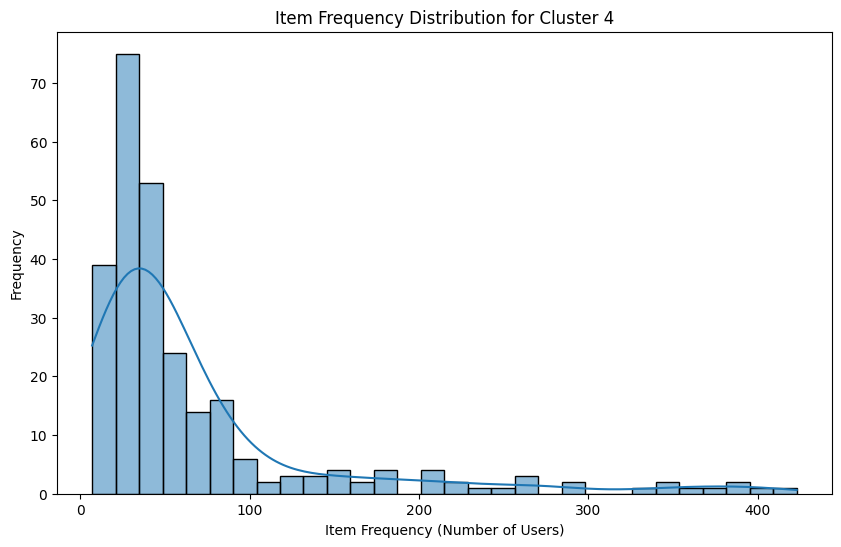

Cluster 4: 10 rules generated.

Processing Cluster 6...
Sparsity of Cluster 6: 0.9495, ize of Cluster is: 534


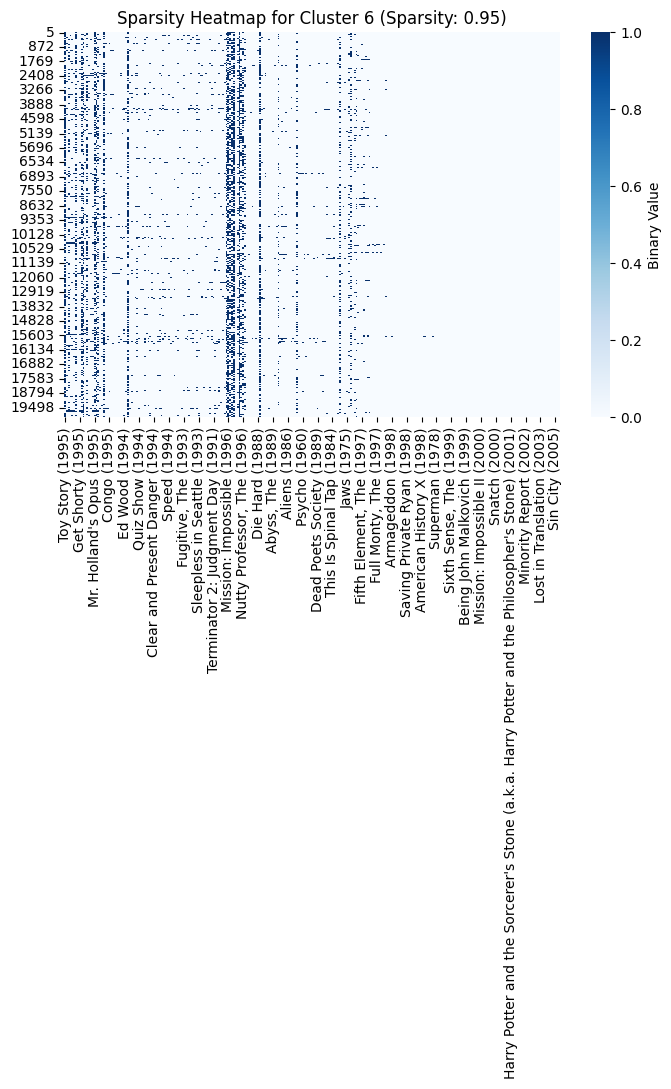

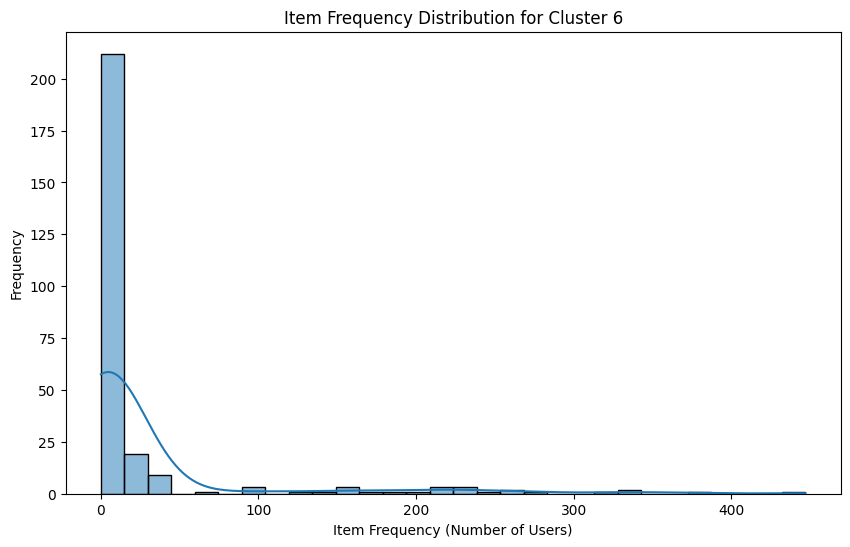

Cluster 6: 8 rules generated.

Processing Cluster 8...
Sparsity of Cluster 8: 0.9635, ize of Cluster is: 3226


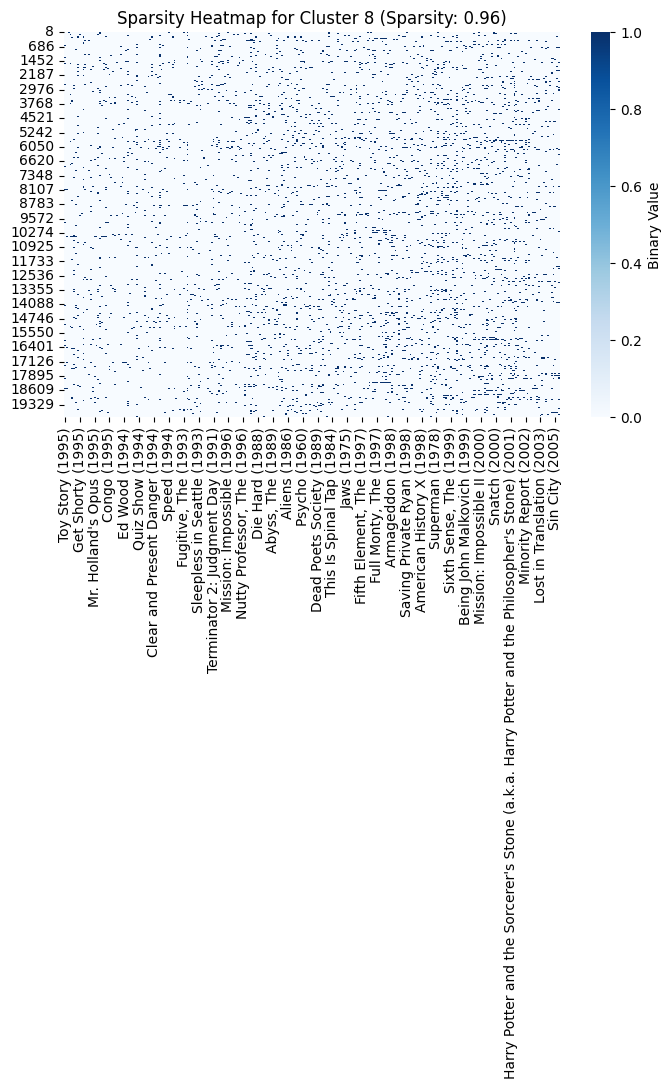

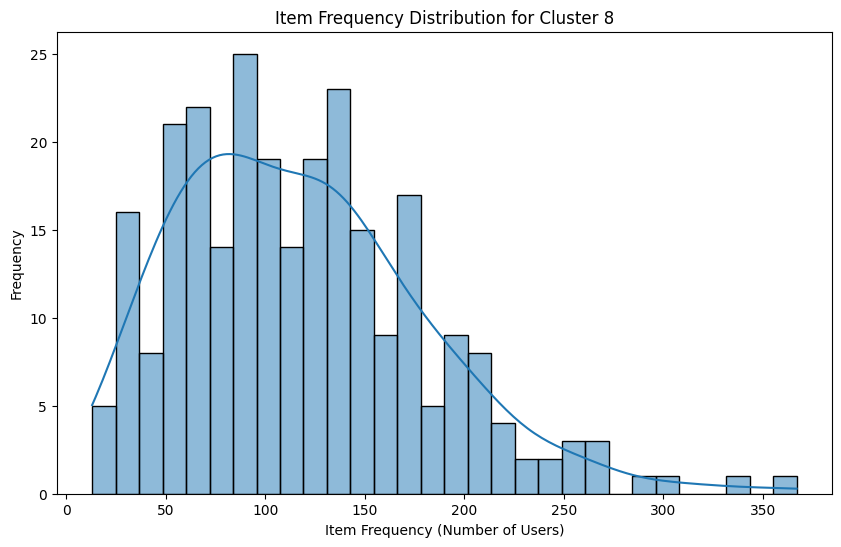

No frequent itemsets found in Cluster 8.

Processing Cluster 9...
Sparsity of Cluster 9: 0.8099, ize of Cluster is: 504


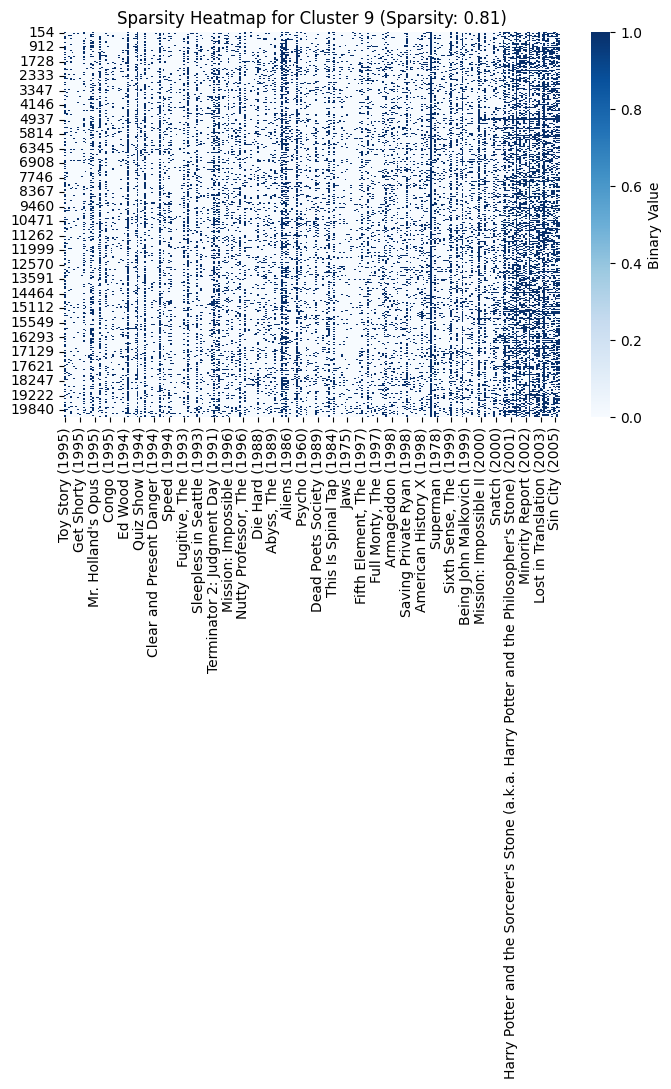

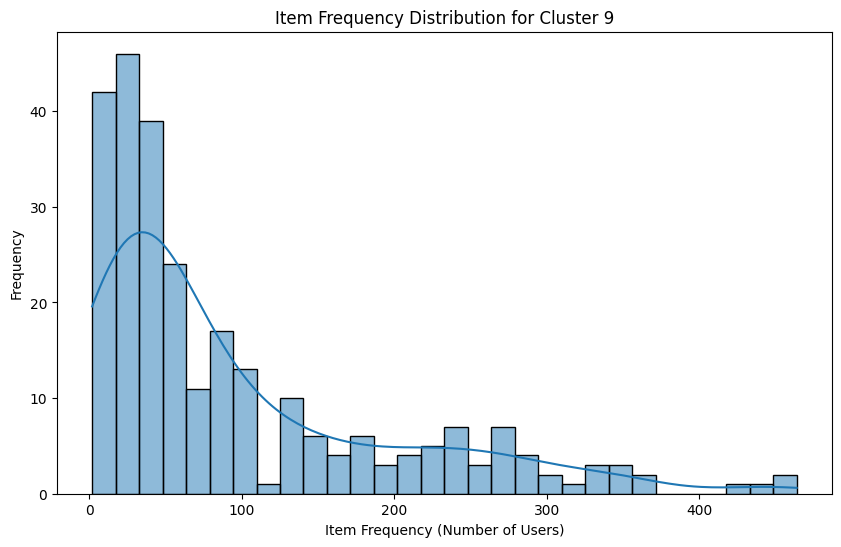

Cluster 9: 1178 rules generated.

Processing Cluster 15...
Sparsity of Cluster 15: 0.9251, ize of Cluster is: 630


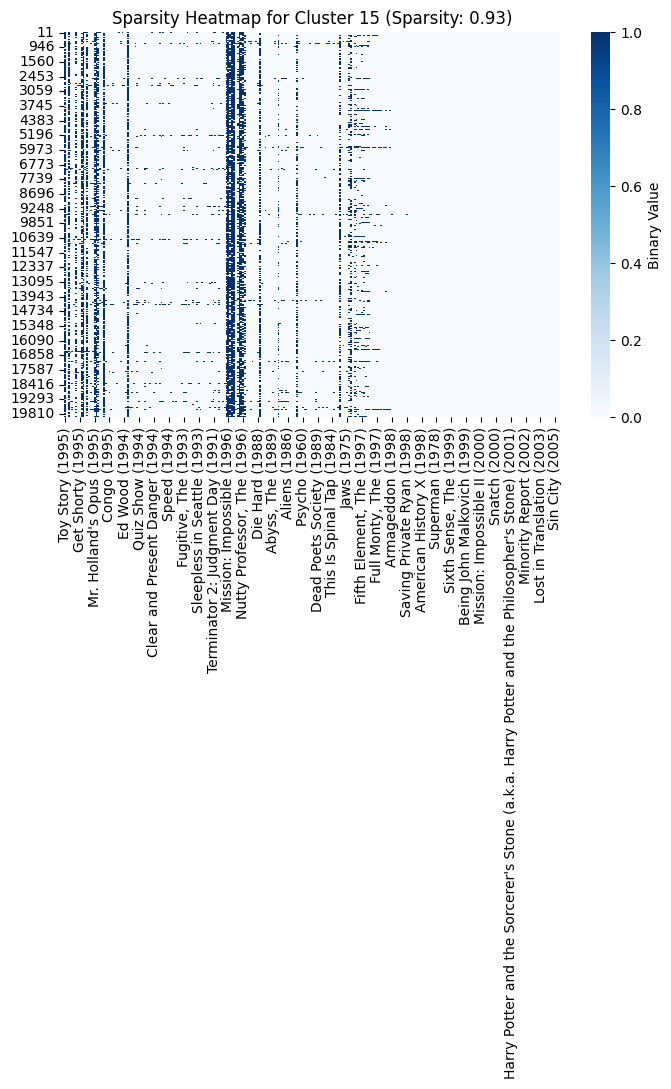

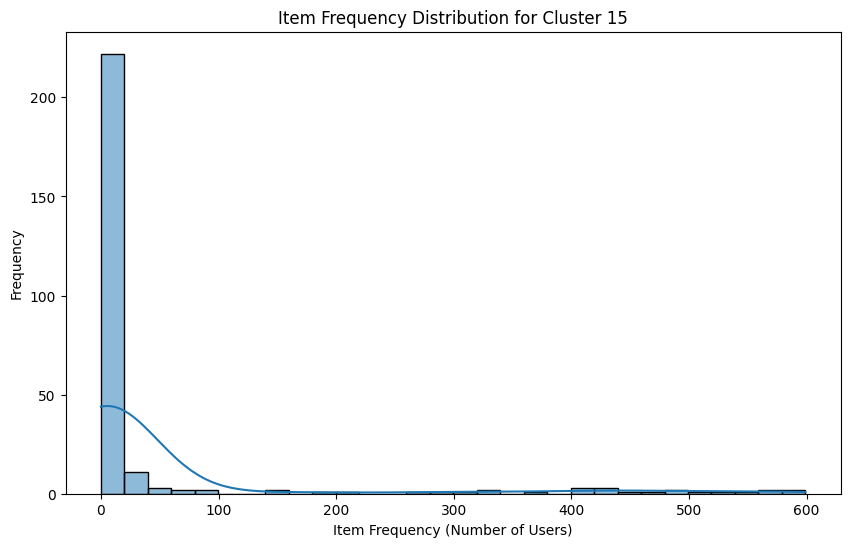

Cluster 15: 8076 rules generated.

Processing Cluster 16...
Sparsity of Cluster 16: 0.9038, ize of Cluster is: 566


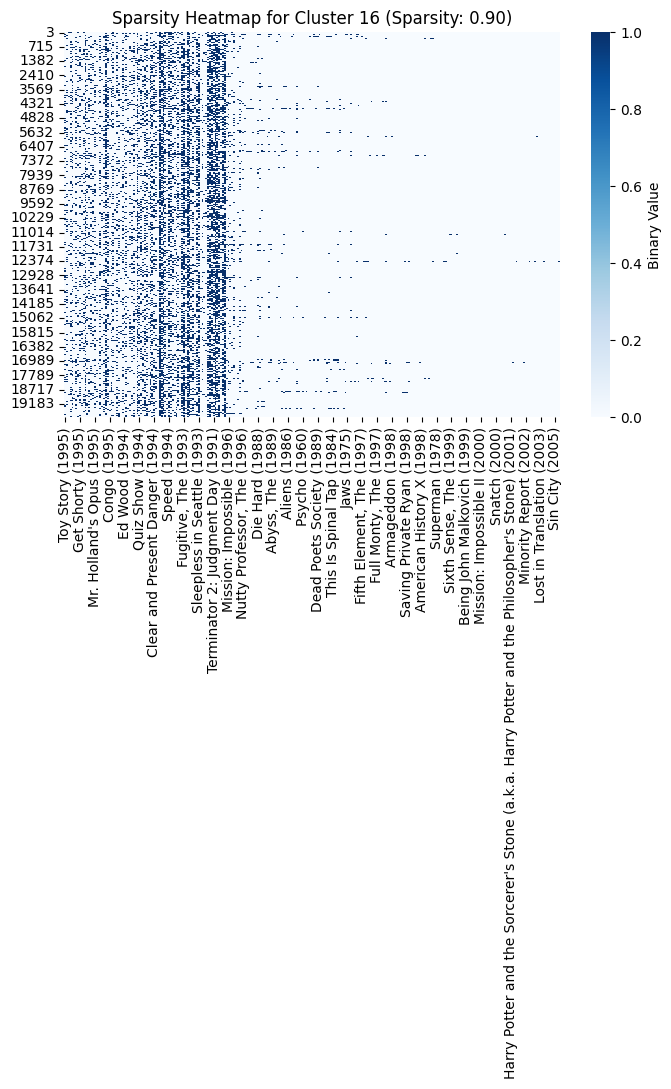

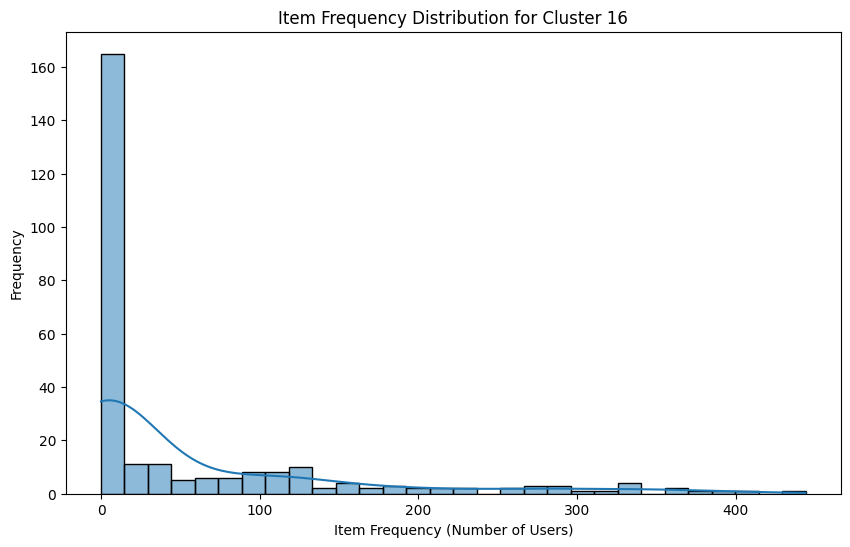

Cluster 16: 8 rules generated.

Processing Cluster 29...
Sparsity of Cluster 29: 0.9254, ize of Cluster is: 813


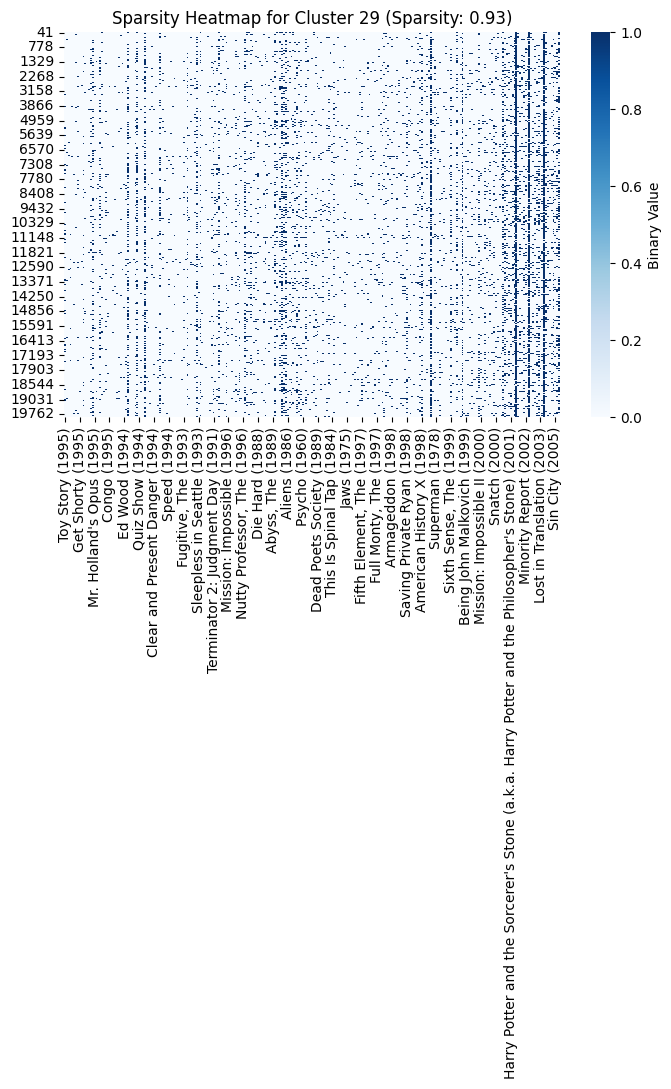

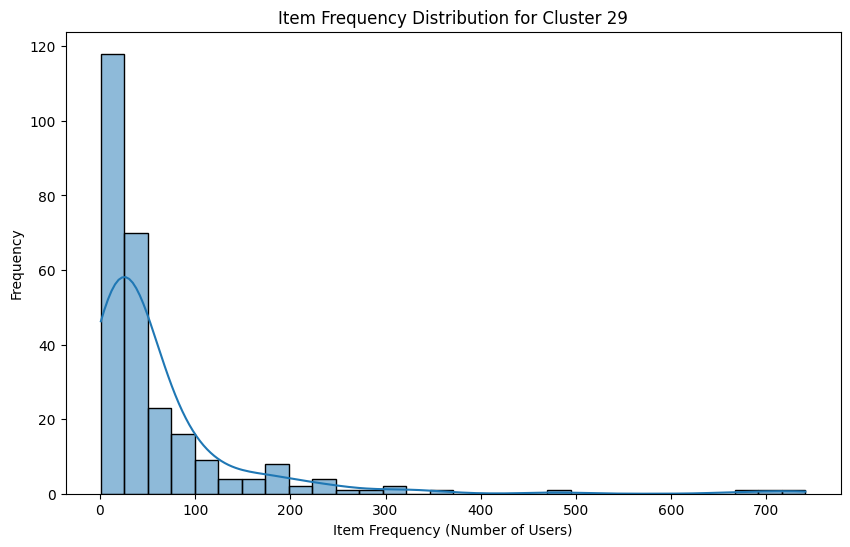

Cluster 29: 12 rules generated.

Processing Cluster 40...
Sparsity of Cluster 40: 0.9478, ize of Cluster is: 1236


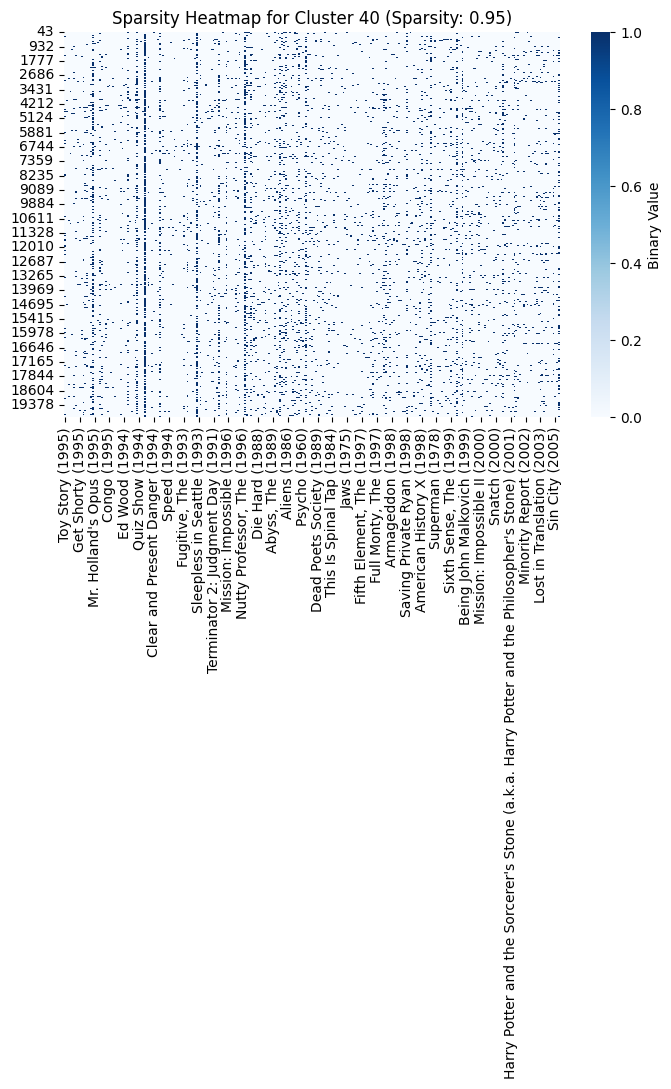

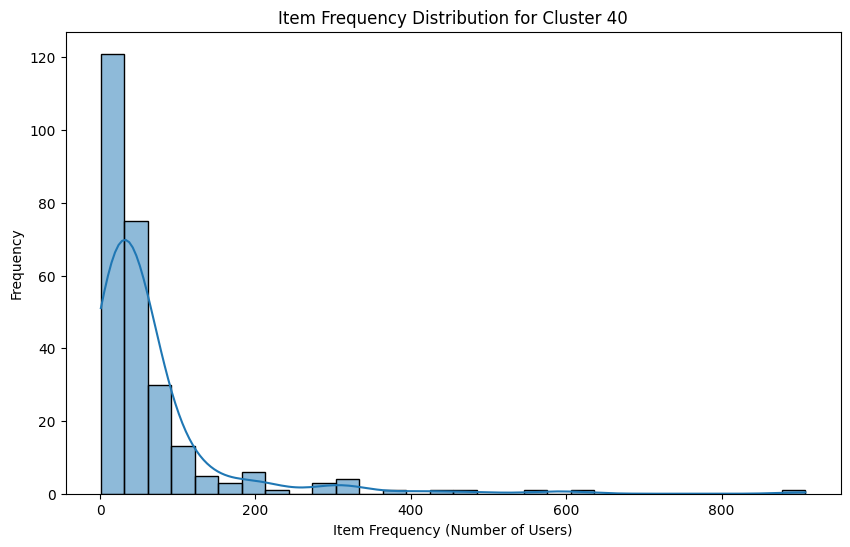

Cluster 40: 0 rules generated.

Processing Cluster 43...
Sparsity of Cluster 43: 0.9181, ize of Cluster is: 537


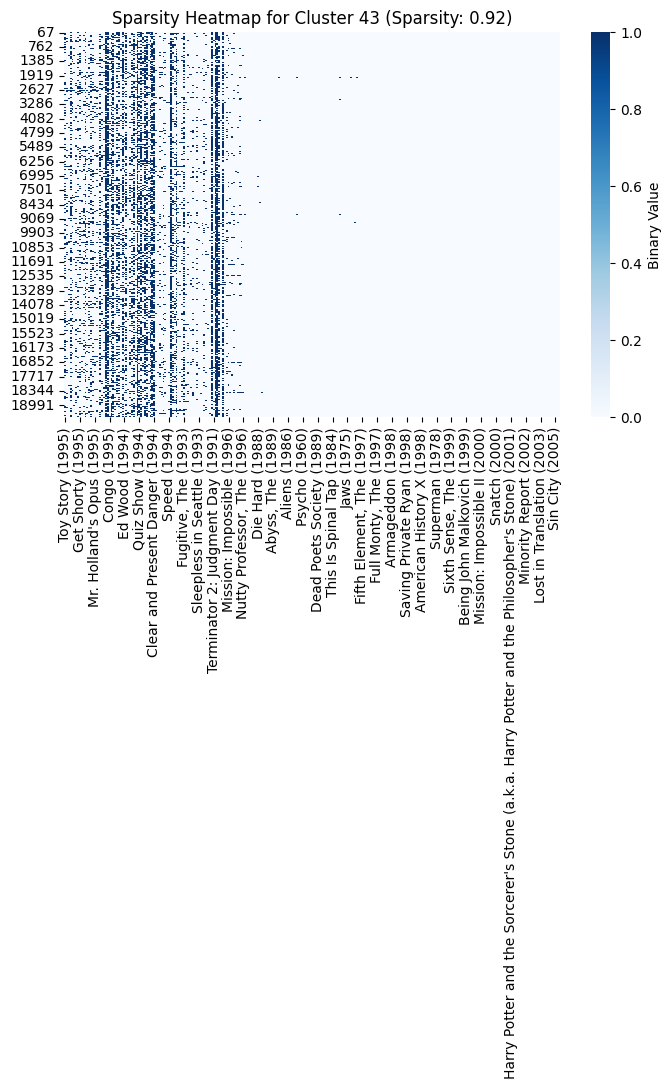

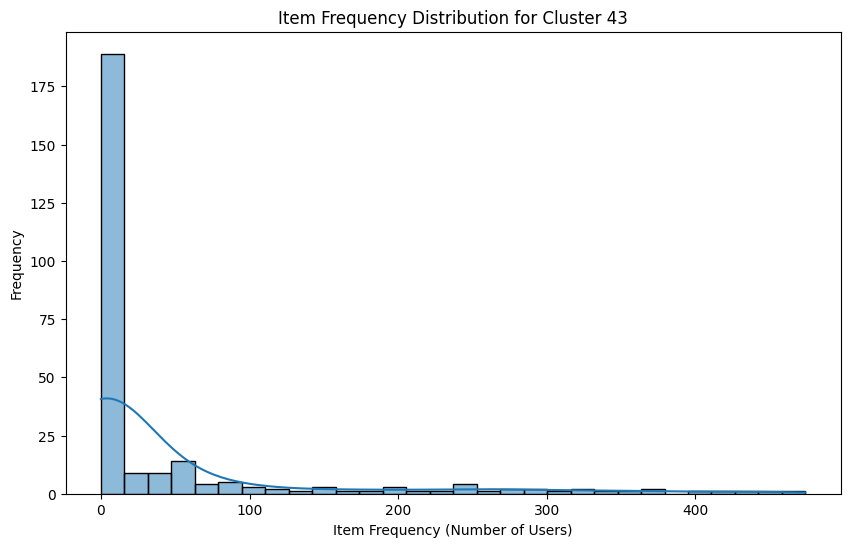

Cluster 43: 196 rules generated.

Processing Cluster 44...
Sparsity of Cluster 44: 0.8688, ize of Cluster is: 603


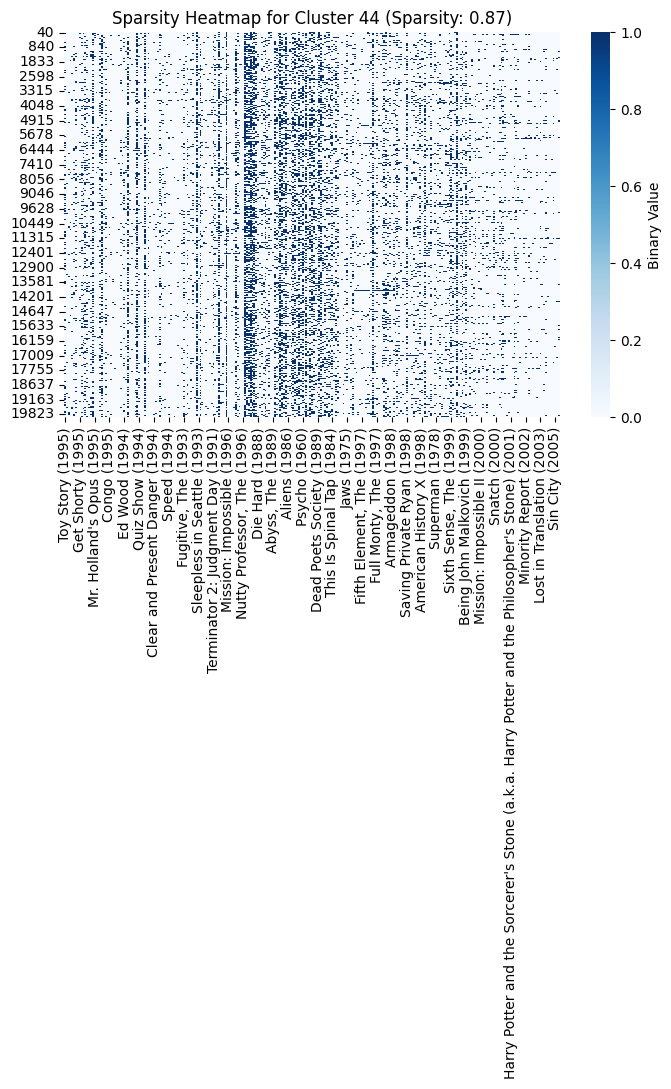

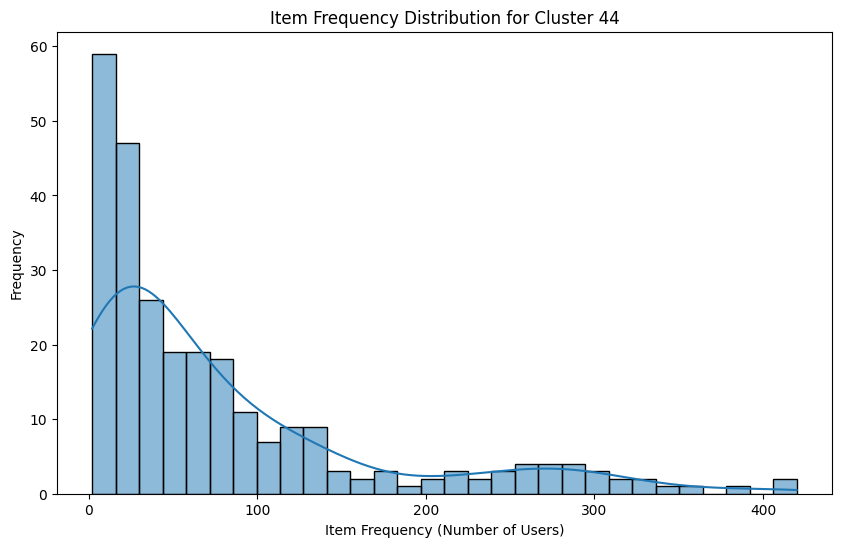

Cluster 44: 0 rules generated.

Processing Cluster 45...
Sparsity of Cluster 45: 0.8914, ize of Cluster is: 585


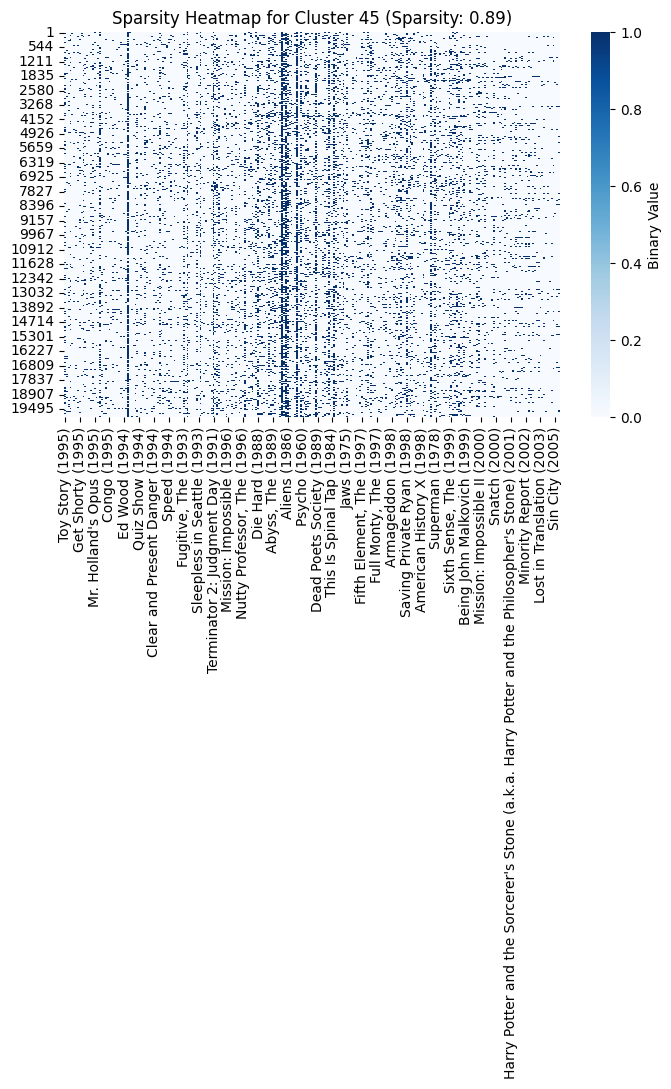

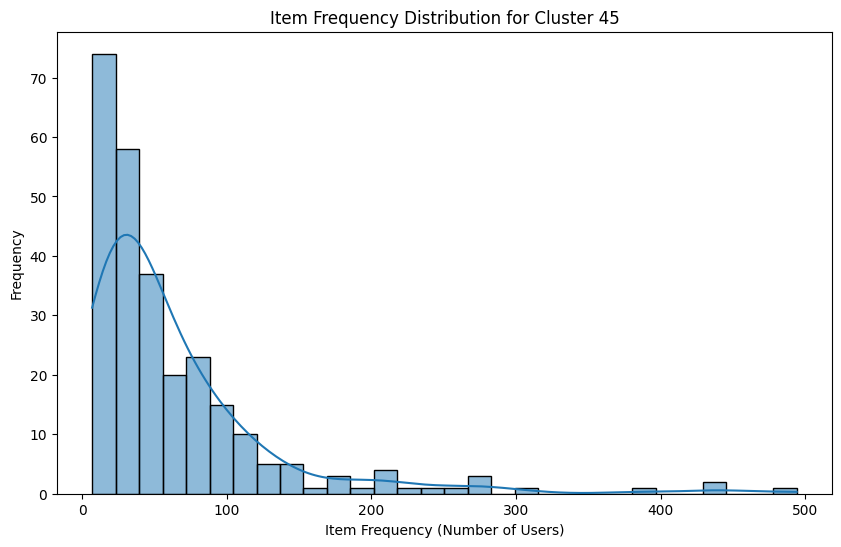

Cluster 45: 16 rules generated.


In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import fpgrowth

def calculate_sparsity(cluster_data):
    """Calculate the sparsity of the cluster data."""
    total_entries = cluster_data.size
    non_zero_entries = cluster_data.values.sum()
    return 1 - (non_zero_entries / total_entries)

def plot_sparsity(cluster_data, cluster_id):
    """Plot the sparsity of a cluster."""
    sparsity = calculate_sparsity(cluster_data)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cluster_data, cbar_kws={'label': 'Binary Value'}, cmap='Blues')
    plt.title(f"Sparsity Heatmap for Cluster {cluster_id} (Sparsity: {sparsity:.2f})")
    plt.show()

def plot_item_frequency_distribution(cluster_data, cluster_id):
    """Plot item frequency distribution for a cluster."""
    item_frequencies = cluster_data.sum(axis=0)  # Sum across rows to get item frequency
    plt.figure(figsize=(10, 6))
    sns.histplot(item_frequencies, bins=30, kde=True)
    plt.title(f"Item Frequency Distribution for Cluster {cluster_id}")
    plt.xlabel('Item Frequency (Number of Users)')
    plt.ylabel('Frequency')
    plt.show()

def process_cluster(cluster_id, df, min_support):
    print(f"\nProcessing Cluster {cluster_id}...")

    # Extract transactions of the current cluster
    cluster_data = df[df['Cluster'] == cluster_id].drop(columns=['Cluster'])

    # Calculate and print sparsity for this cluster
    sparsity = calculate_sparsity(cluster_data)
    print(f"Sparsity of Cluster {cluster_id}: {sparsity:.4f}, ize of Cluster is: {len(cluster_data)}")

    # Plot sparsity heatmap for this cluster
    plot_sparsity(cluster_data, cluster_id)

    # Plot item frequency distribution
    plot_item_frequency_distribution(cluster_data, cluster_id)

    # Run FPGrowth
    frequent_itemsets = fpgrowth(cluster_data, min_support=min_support, use_colnames=True)

    if frequent_itemsets.empty:
        print(f"No frequent itemsets found in Cluster {cluster_id}.")
        return None

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

    print(f"Cluster {cluster_id}: {len(rules)} rules generated.")
    return cluster_id, {"frequent_itemsets": frequent_itemsets, "rules": rules}

def find_clusters_rules(df, min_support):
    cluster_results = {}
    for cluster_id in sorted(df['Cluster'].unique()):

        cluster_data = df[df['Cluster'] == cluster_id].drop(columns=['Cluster'])
        # Calculate and filter clusters with less sparsity than desired.
        if df['Cluster'].value_counts()[cluster_id] < 0.025 * len(transactions):
            cluster_results[cluster_id] = cluster_id, {"frequent_itemsets": None, "rules": None}
            continue
        cluster_results[cluster_id] = process_cluster(cluster_id, df, min_support)
    return cluster_results

cluster_results = find_clusters_rules(transactions, min_support=0.5)


In [92]:
from sklearn.metrics import silhouette_score

score=silhouette_score(df, df['Cluster'])
print(f"silhouette score of clustering is: {score}")


silhouette score of clustering is: 0.13930834723643123


In [93]:

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*invalid value encountered in divide*")
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*DataFrames with non-bool types result in worse computationalperformance*")

from mlxtend.frequent_patterns import fpgrowth, association_rules
import numpy as np

# Function to compute global support
import numpy as np

def calculate_global_support(itemset, full_data):
    """Calculate global support of an itemset across the entire transactions dataset efficiently."""
    itemset = list(itemset)  # Ensure itemset is a list
    relevant_rows = full_data[itemset].sum(axis=1) == len(itemset)  # Check if all items are present
    return relevant_rows.mean()  # Equivalent to sum(relevant_rows) / len(full_data)


In [94]:
import pandas as pd

# Assuming you have a function to calculate global support
def calculate_global_support(itemset, full_data):
    """Calculate global support of an itemset across the entire transactions dataset efficiently."""
    itemset = list(itemset)  # Ensure itemset is a list
    relevant_rows = full_data[itemset].sum(axis=1) == len(itemset)  # Check if all items are present
    return relevant_rows.mean()  # Equivalent to sum(relevant_rows) / len(full_data)

# Initialize an empty list to store all the rules
all_rules = []

# Loop through all cluster results and combine the rules
for id, cluster_data in cluster_results.items():
    if cluster_data is None:
        continue
    rules = cluster_data[1]["rules"]
    if rules is None or rules.empty:
        continue
    rules['Cluster'] = id  # Add a column to track the cluster ID
    all_rules.append(rules)

# Concatenate all the rules into a single DataFrame
all_rules_df = pd.concat(all_rules, ignore_index=True)


print(f"size of rules **before** dropping duplicated across clusters is: {len(all_rules_df)}")


# Remove duplicates if needed
all_rules_df = all_rules_df.drop_duplicates(subset=['antecedents', 'consequents'])


print(f"size of rules after dropping duplicated across clusters is: {len(all_rules_df)}")

# Now calculate the global metrics for all rules in one go
all_rules_df['global_antecedent_support'] = all_rules_df['antecedents'].apply(
    lambda x: calculate_global_support(set(x), transactions)
)

all_rules_df['global_consequent_support'] = all_rules_df['consequents'].apply(
    lambda x: calculate_global_support(set(x), transactions)
)

# Calculate global rule support (for antecedent + consequent together)
all_rules_df['global_rule_support'] = all_rules_df.apply(
    lambda row: calculate_global_support(set(row['antecedents']).union(set(row['consequents'])) , transactions),
    axis=1
)

# Calculate global confidence
all_rules_df['global_confidence'] = all_rules_df['global_rule_support'] / all_rules_df['global_antecedent_support']

# Calculate global lift
all_rules_df['global_lift'] = all_rules_df['global_confidence'] / all_rules_df['global_consequent_support']

# Output the global metrics for the best rules (sorted by global lift)
top_rules = all_rules_df.sort_values(by='global_lift', ascending=False).head(3)

# Print the top k rules
for index, row in top_rules.iterrows():
    print(f"Cluster {row['Cluster']}:")
    print(f"Antecedents: {row['antecedents']}, Consequents: {row['consequents']}")
    print(f"Global Lift: {row['global_lift']:.4f}")
    print(f"Global Confidence: {row['global_confidence']:.4f}")
    print(f"Global Rule Support: {row['global_rule_support']:.4f}")
    print(f"Global Antecedent Support: {row['global_antecedent_support']:.4f}")
    print(f"Global Consequent Support: {row['global_consequent_support']:.4f}")
    print("-" * 50)

print(f"mean global lift is: {all_rules_df['global_lift'].mean()}")
print(f"mean global support is: {all_rules_df['global_rule_support'].mean()}")
print(f"mean global confidence is: {all_rules_df['global_confidence'].mean()}")


size of rules **before** dropping duplicated across clusters is: 9518
size of rules after dropping duplicated across clusters is: 9482
Cluster 15:
Antecedents: frozenset({'Eraser (1996)', 'Mission: Impossible (1996)', 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)'}), Consequents: frozenset({'Independence Day (a.k.a. ID4) (1996)', 'Broken Arrow (1996)', 'Rock, The (1996)', 'Twister (1996)'})
Global Lift: 7.6054
Global Confidence: 0.6153
Global Rule Support: 0.0431
Global Antecedent Support: 0.0701
Global Consequent Support: 0.0809
--------------------------------------------------
Cluster 15:
Antecedents: frozenset({'Independence Day (a.k.a. ID4) (1996)', 'Broken Arrow (1996)', 'Rock, The (1996)', 'Twister (1996)'}), Consequents: frozenset({'Eraser (1996)', 'Mission: Impossible (1996)', 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)'})
Global Lift: 7.6054
Global Confidence: 0.5328
Global Rule Support: 0.0431
Global Antecedent Support: 0.0809
Global Consequent Support: 0.0701
------------------

In [95]:
comparable_rules = all_rules_df[all_rules_df['global_rule_support'] >= 0.25]
print(f"number of comparable rules is: {len(comparable_rules)}")
if  comparable_rules is None or comparable_rules.empty:
  print(f"mean global lift is: {comparable_rules['global_lift'].mean()}")
else:
  print(f"mean global lift is: {comparable_rules['global_lift'].mean()}")

number of comparable rules is: 22
mean global lift is: 1.7144046546026828


In [96]:
comparable_rules.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,Cluster,global_antecedent_support,global_consequent_support,global_rule_support,global_confidence,global_lift
14,(Jurassic Park (1993)),(Forrest Gump (1994)),0.733102,0.686308,0.532062,0.725768,1.057496,1.0,0.028928,1.143892,0.203710,0.599609,0.125792,0.750510,4,0.44335,0.49420,0.34865,0.786399,1.591257
15,(Forrest Gump (1994)),(Jurassic Park (1993)),0.686308,0.733102,0.532062,0.775253,1.057496,1.0,0.028928,1.187545,0.173322,0.599609,0.157927,0.750510,4,0.49420,0.44335,0.34865,0.705484,1.591257
16,(Forrest Gump (1994)),"(Silence of the Lambs, The (1991))",0.686308,0.684575,0.504333,0.734848,1.073437,1.0,0.034503,1.189601,0.218090,0.582000,0.159382,0.735779,4,0.49420,0.46705,0.33175,0.671287,1.437291
17,"(Silence of the Lambs, The (1991))",(Forrest Gump (1994)),0.684575,0.686308,0.504333,0.736709,1.073437,1.0,0.034503,1.191424,0.216891,0.582000,0.160669,0.735779,4,0.46705,0.49420,0.33175,0.710309,1.437291
18,(Jurassic Park (1993)),(Braveheart (1995)),0.733102,0.681109,0.512998,0.699764,1.027388,1.0,0.013676,1.062132,0.099882,0.569231,0.058498,0.726472,4,0.44335,0.39640,0.27615,0.622871,1.571320


Index(['antecedents', 'consequents', 'antecedent support',
       'consequent support', 'support', 'confidence', 'lift',
       'representativity', 'leverage', 'conviction', 'zhangs_metric',
       'jaccard', 'certainty', 'kulczynski', 'Cluster',
       'global_antecedent_support', 'global_consequent_support',
       'global_rule_support', 'global_confidence', 'global_lift'],
      dtype='object')


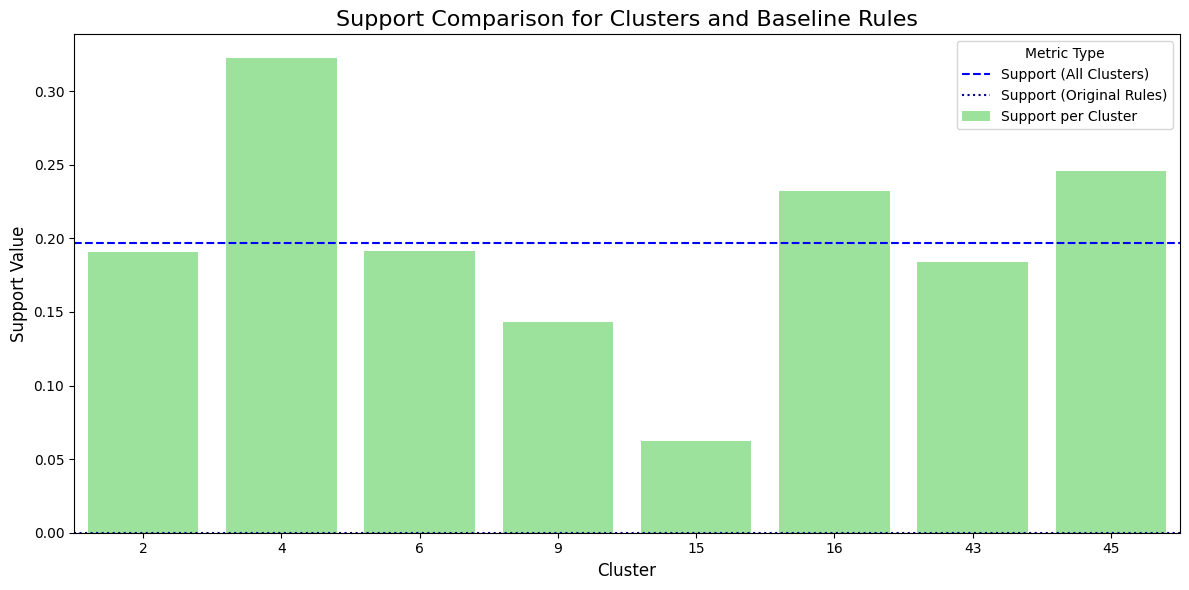

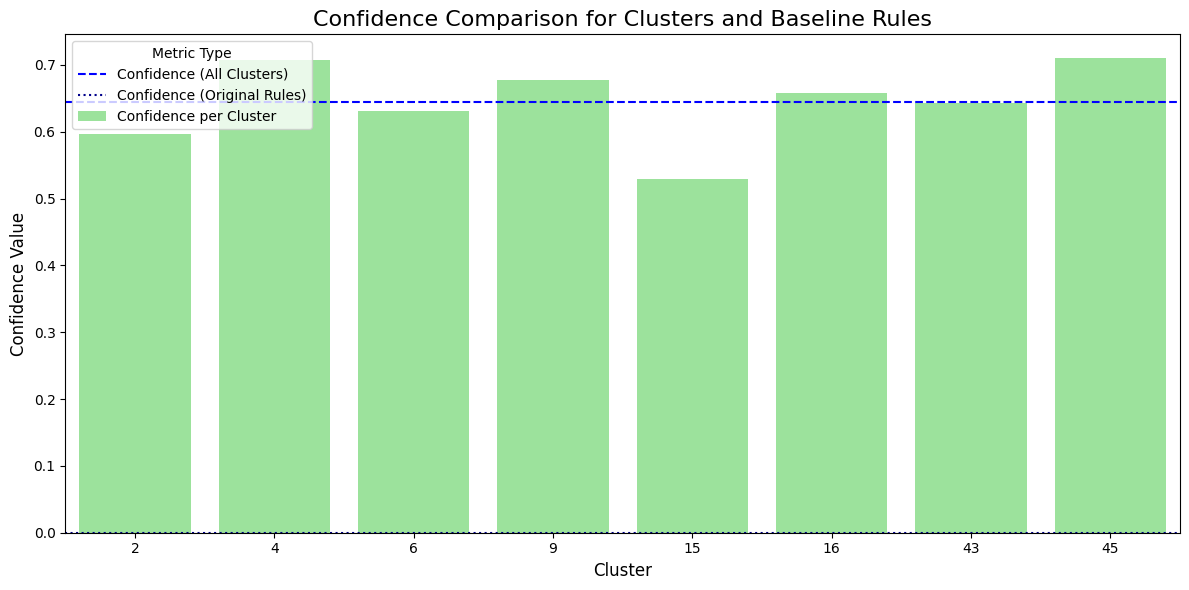

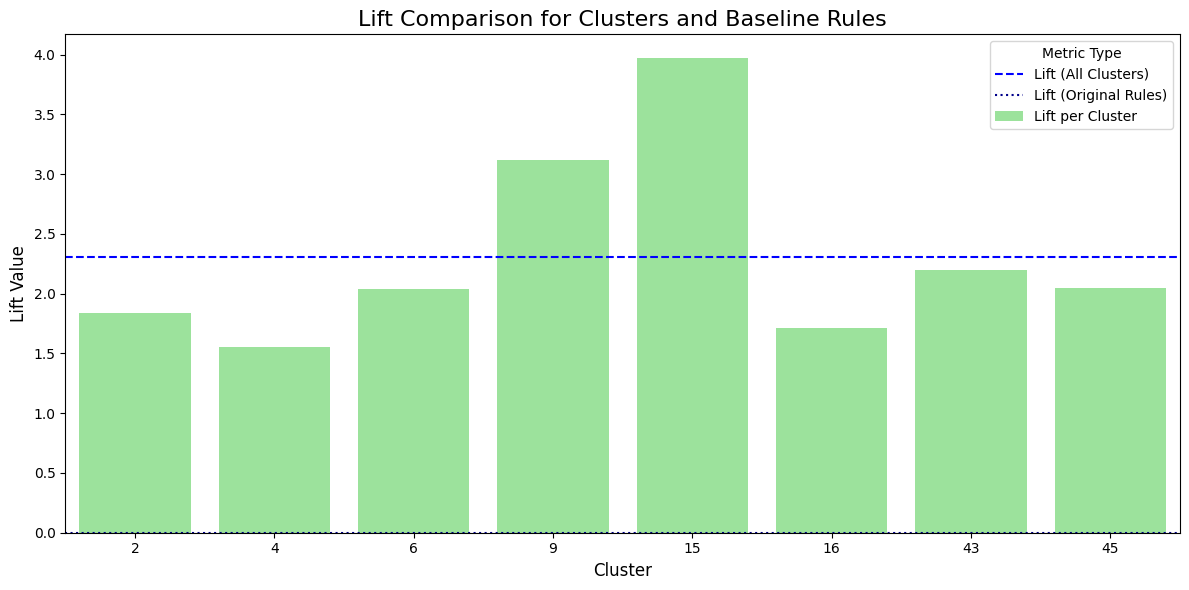

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_rules_comparison(all_rules_df):
  # Ensure overall_metrics is properly initialized
  overall_metrics = {
      'Support': {},
      'Confidence': {},
      'Lift': {}
  }

  # Group the rules by cluster and calculate the mean for each metric
  cluster_metrics_df = all_rules_df.groupby('Cluster')[['global_rule_support', 'global_confidence', 'global_lift']].mean().reset_index()

  # Compute global averages for all clusters
  if not cluster_metrics_df.empty:
      avg_support_all_clusters = cluster_metrics_df['global_rule_support'].mean()
      avg_confidence_all_clusters = cluster_metrics_df['global_confidence'].mean()
      avg_lift_all_clusters = cluster_metrics_df['global_lift'].mean()
  else:
      avg_support_all_clusters = avg_confidence_all_clusters = avg_lift_all_clusters = 0

  # Add overall metrics for all clusters
  overall_metrics['Support']['All Clusters'] = avg_support_all_clusters
  overall_metrics['Confidence']['All Clusters'] = avg_confidence_all_clusters
  overall_metrics['Lift']['All Clusters'] = avg_lift_all_clusters

  # Compute metrics for original rules
  if "original_rules" in locals() and original_rules is not None and not original_rules.empty:
      avg_support_original = original_rules["support"].mean()
      avg_confidence_original = original_rules["confidence"].mean()
      avg_lift_original = original_rules["lift"].mean()
  else:
      avg_support_original = avg_confidence_original = avg_lift_original = 0

  # Add original rules metrics to overall metrics
  overall_metrics['Support']['Original Rules'] = avg_support_original
  overall_metrics['Confidence']['Original Rules'] = avg_confidence_original
  overall_metrics['Lift']['Original Rules'] = avg_lift_original

  # Prepare the data for plotting each metric separately
  metrics = ['global_rule_support', 'global_confidence', 'global_lift']
  metric_mapping = {'global_rule_support': 'Support', 'global_confidence': 'Confidence', 'global_lift': 'Lift'}

  # Create individual plots for each metric
  for metric in metrics:
      fig, ax = plt.subplots(figsize=(12, 6))

      # Plot the metrics for each cluster
      sns.barplot(x='Cluster', y=metric, data=cluster_metrics_df, color='lightgreen', label=f'{metric_mapping[metric]} per Cluster', ax=ax)

      # Plot overall metrics (all clusters and original rules)
      ax.axhline(y=overall_metrics[metric_mapping[metric]]['All Clusters'], color='blue', linestyle='--', label=f'{metric_mapping[metric]} (All Clusters)')
      ax.axhline(y=overall_metrics[metric_mapping[metric]]['Original Rules'], color='darkblue', linestyle=':', label=f'{metric_mapping[metric]} (Original Rules)')

      # Add labels and title
      ax.set_title(f'{metric_mapping[metric]} Comparison for Clusters and Baseline Rules', fontsize=16)
      ax.set_xlabel('Cluster', fontsize=12)
      ax.set_ylabel(f'{metric_mapping[metric]} Value', fontsize=12)
      ax.legend(title='Metric Type')

      # Show the plot
      plt.tight_layout()
      plt.show()

plot_rules_comparison(all_rules_df)


# 2. Online Retail Datsaset